In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from os.path import join as pjoin
import matplotlib.font_manager as font_manager 

In [2]:
# define path
# make sure the dataset_path are modified based on your personal dataset downloading directory
dataset_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/data_upload/HAD'
support_path = './support_files'
# change to path of current file
os.chdir(os.path.abspath(''))
# load sports info
info_path = pjoin(support_path, 'sports_or_not.mat')
sports_info = sio.loadmat(info_path)['sports_label'].squeeze()

In [3]:
sub_names = ['sub-%02d'%(i+1) for i in range(30)]
beh_info_acc, beh_info_rr = {}, {}
acc_sum, rr_sum = [], []
for sub_name in sub_names:
    sub_events_path = pjoin(dataset_path, sub_name)
    sess_names = [_ for _ in os.listdir(sub_events_path) if ('action' in _) and ('5' not in _) and ('6' not in _)]
    # define container
    sub_acc, sub_rr = [], [] # rr means response rate
    # loop sess and run
    for sess in sess_names:
        for run in np.linspace(1,12,12, dtype=int):
            sess_beh = f'sess{sess[-2:]}'
            # open ev file
            events_file = pjoin(sub_events_path, sess, 'func', '{:s}_{:s}_task-action_run-{:02d}_events.tsv'.format(sub_name, sess, run))
            ev_df =  pd.read_csv(events_file, sep='\t')
            # open response info
            response = ev_df['response']
            condition = ev_df['trial_type'].values
            n_miss = response.isnull().sum()
            # handle situation when the run misses all value
            if n_miss==response.shape[0]:
                continue
            # compute response accuracy and response rate here 
            response_rate = 1-(n_miss/response.shape[0])
            truth_label = sports_info[(condition-1).astype(int)]
            response_acc = (response==truth_label).sum()/(response.shape[0]-n_miss)
            # merge info into containers
            sub_acc.append(response_acc)
            sub_rr.append(response_rate)
    # print('%s in %02d runs: acc: %.3f; response rate: %.3f'%(sub_name, len(sub_acc), np.array(sub_acc).mean(), np.array(sub_rr).mean()))
    beh_info_acc[sub_name] = sub_acc
    beh_info_rr[sub_name] = sub_rr
    acc_sum.extend(sub_acc)
    rr_sum.extend(sub_rr)
# compute average response rate and accuracy
print('Average accuracy across participants is %.3f'%(np.array(acc_sum).mean()))
print('Average response rate across participants is %.3f'%(np.array(rr_sum).mean()))

Average accuracy across participants is 0.834
Average response rate across participants is 0.946


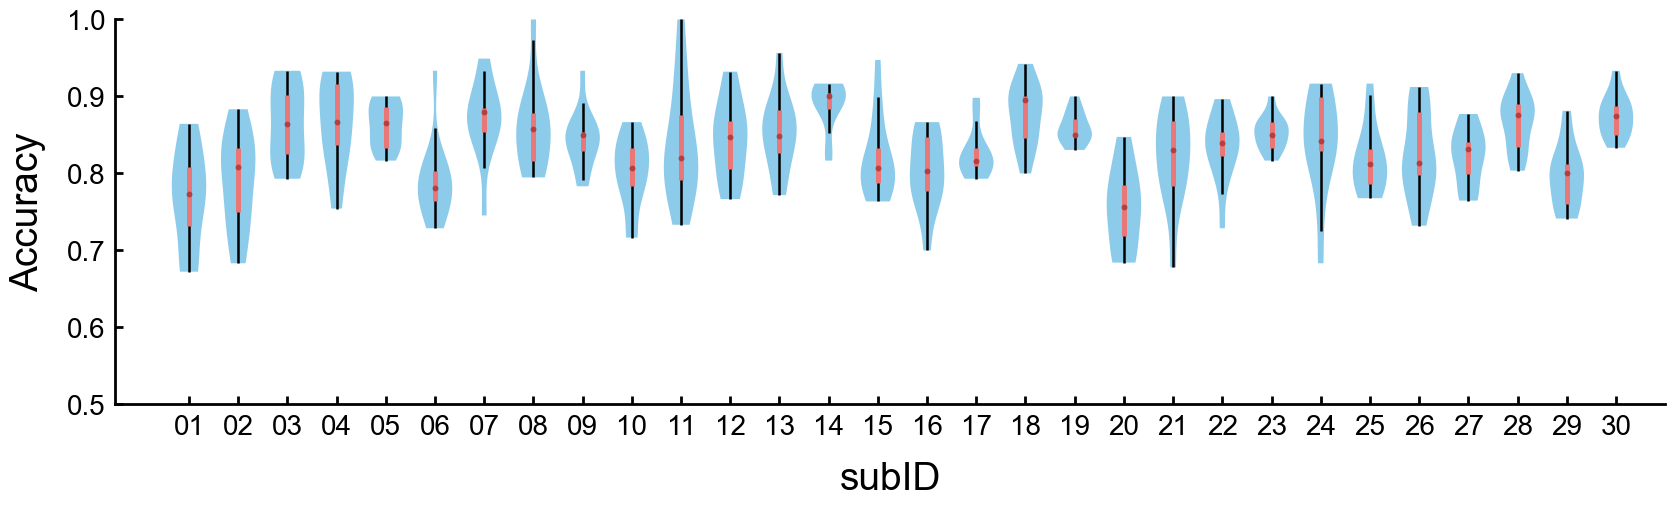

In [4]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
mpl.rcParams.update({'font.size': 10.5, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
fig,ax = plt.subplots(figsize=(20,5))
width=0.7

font_size = 11
for i, sub_name in enumerate(beh_info_acc.keys()) :
    data = beh_info_acc[sub_name]
    parts = ax.violinplot(data, positions=[i], widths=width,showextrema=False,showmedians=False, vert=True)
    for pc in parts['bodies']:
        pc.set_facecolor('#81C6E8')
        pc.set_alpha(0.9)
    q1, medians, q3 = np.percentile(data, [25, 50, 75], axis=0)
    whiskers = np.array([adjacent_values(np.sort(data), q1, q3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    ax.scatter(i, medians, marker='o', color='#B73E3E', s=10, zorder=3)
    ax.vlines(i, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1.8)
    ax.vlines(i, q1, q3, color='red',edgecolors='#E97777', linestyle='-', lw=3.6)
    
# ax.set_xlim([0.02,0.8])
# ax.set_yticks([0,1,2,3])
# ax.set_yticklabels([],fontsize=10.5)
font = font_manager.FontProperties(fname=pjoin(support_path, 'arial.ttf'), size=20, weight='bold')
ax.set_ylim([0.5,1.0])
ax.set_xlim([-1.5,30])
ax.set_xticks(np.arange(30))
ax.set_xticklabels(['%02d'%(i+1) for i in np.arange(30)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.tick_params(labelsize=20, width=2, length=6, direction="in", pad=7)
# plot detail
plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)
plt.xlabel('subID', fontproperties=font, size=28, labelpad=15)
plt.ylabel('Accuracy', fontproperties=font, size=28, labelpad=15)
plt.show()
# fig.savefig(f'/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD/validation/support_files/beh_acc.jpg',dpi=300,bbox_inches='tight')

